## The Context




This post aims to develop a Python pipeline to recover the rotation and translation between two images that have undergone a rigid euclidean transformation.

We will apply this to the problem of determining both the rotation and the translation between two different mini-maps.

![](https://cgcooke.github.io/Blog//images/2020-12-22-The-Log-Polar-Transform-In-Practice/homographies.png)

While writing this post, I borrowed heavily from this [example](https://scikit-image.org/docs/stable/auto_examples/registration/plot_register_rotation.html#sphx-glr-auto-examples-registration-plot-register-rotation-py), as well as this fantastic series of [posts](https://sthoduka.github.io/imreg_fmt/docs/overall-pipeline/). Both are well worth a read and go into significantly more detail. Finally, the original [paper](https://pdfs.semanticscholar.org/6dfe/0a0173f8b2087bc052108184f65299f1b605.pdf), which first described the method, is also worth a read.

## The Pipeline

At a high level, our pipeline is as follows:

First, we find the rotation:
* Preprocess Images:
    * Apply Difference of Gaussians Filter (DOG)
    * Window Function (WINDOW)
* Compute Power Spectral Density of images (PSD)
* Compute the Log Polar Transform of PSD (LPT)
* Find translation in Log Polar Domain using Cross-Correlation (XCOR) 

![](https://cgcooke.github.io/Blog//images/2020-12-22-The-Log-Polar-Transform-In-Practice/Rotation_Pipeline.png)

Once we have found the rotation, we can then find the translation:
* Rotate one of the images (ROTATE)
* Find translation using Cross-Correlation (XCOR)

![](https://cgcooke.github.io/Blog//images/2020-12-22-The-Log-Polar-Transform-In-Practice/Translation_Pipeline.png)

Now let's go into the details of the implementation.

Let's start by importing the libraries we will need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import skimage.io
import skimage.transform

from skimage.color import rgb2gray
import skimage.filters

plt.rcParams['figure.figsize'] = [10, 10]

This function compares two images/arrays and checks how well they match for any x/y shift. It's a simplified version of a function from skimage (*skimage.registration.phase_cross_correlation*), and you can see the original source code [here](https://github.com/scikit-image/scikit-image/blob/master/skimage/registration/_phase_cross_correlation.py#L109-L276). In a previous [post](https://cgcooke.github.io/Blog/computer%20vision/2020/12/19/FFT-Phase-Correlation.html) I explained how it works in more detail.

In [2]:
def phase_cross_correlation(reference_image, moving_image):
    # Adapted from skimage.registration.phase_cross_correlation
    src_freq = np.fft.fft2(reference_image)
    target_freq = np.fft.fft2(moving_image)

    # Whole-pixel shift - Compute cross-correlation by an IFFT
    shape = src_freq.shape
    image_product = src_freq * target_freq.conj()
    cross_correlation = np.fft.ifft2(image_product)
    
    # Locate maximum
    maxima = np.unravel_index(np.argmax(np.abs(cross_correlation)), cross_correlation.shape)
    midpoints = np.array([np.fix(axis_size / 2) for axis_size in shape])

    shifts = np.array(maxima, dtype=np.float64)
    shifts[shifts > midpoints] -= np.array(shape)[shifts > midpoints]
    
    return np.abs(cross_correlation), shifts

Let's start by loading the image, converting it to grayscale, and then mean-centring it.

In [3]:
frame = skimage.io.imread('data/2020-12-20-The-Log-Polar-Transform/Frame.jpg')
img1 = rgb2gray(frame[50:165,55:170])
img1 -= img1.mean()

We can now create a synthetic example by first translating and then rotating the image we loaded. I've arbitrarily chosen to rotate the image by 30 degrees clockwise and shift it down and to the right by 10 and 20 pixels, respectively.

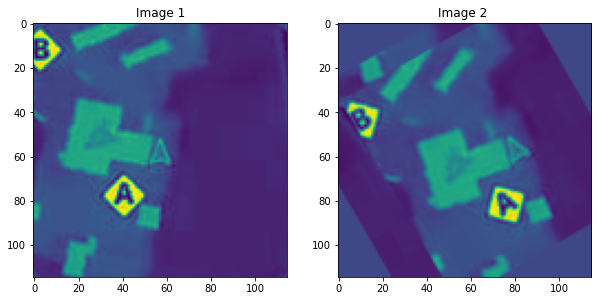

In [4]:
angle_degrees = 30
shift_y_pixels = 10
shift_x_pixels = 20

translated = np.roll(img1, shift_y_pixels, axis=0)
translated = np.roll(translated, shift_x_pixels, axis=1)

img2 = skimage.transform.rotate(translated, angle_degrees)

fig, axes = plt.subplots(1, 2)
ax = axes.ravel()
ax[0].set_title("Image 1")
ax[0].imshow(img1)
ax[1].set_title("Image 2 ")
ax[1].imshow(img2)
plt.show()

## Finding the Rotation
Now that we have two images, we can start finding the rotation between them.

We can start by performing *Difference of Gaussians* filtering as a form of feature engineering/preprocessing.

Next, we window the images, which will help reduce the impact of the image's edges on the image's frequency spectrum.

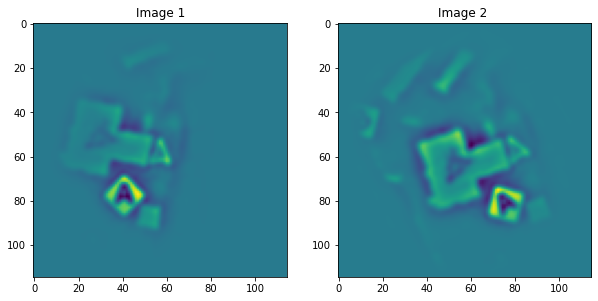

In [5]:
# First, band-pass filter both images
img1_dog = skimage.filters.difference_of_gaussians(img1, 1, 4)
img2_dog = skimage.filters.difference_of_gaussians(img2, 1, 4)

# window images
wimage_1 = img1_dog * skimage.filters.window('hann', img1.shape)
wimage_2 = img2_dog * skimage.filters.window('hann', img2.shape)

fig, axes = plt.subplots(1, 2)
ax = axes.ravel()
ax[0].set_title("Image 1")
ax[0].imshow(wimage_1)
ax[1].set_title("Image 2 ")
ax[1].imshow(wimage_2)
plt.show()

We compute each image's *Power Spectral Density* (PSD).

While it's not immediately obvious, if we look carefully at the PSD of each image, we can notice a slight (30-degree) rotation between the two. 

The beauty of the PSD is that it is invariant to the translation of the two images.

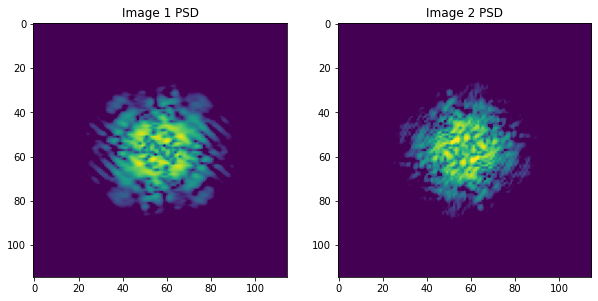

In [6]:
# work with shifted FFT magnitudes
image1_fs = np.abs(np.fft.fftshift(np.fft.fft2(wimage_1)))**2
image2_fs = np.abs(np.fft.fftshift(np.fft.fft2(wimage_2)))**2


fig, axes = plt.subplots(1, 2)
ax = axes.ravel()
ax[0].set_title("Image 1 PSD")
ax[0].imshow(np.log(image1_fs),vmin=0,vmax=np.log(image1_fs).max())


ax[1].set_title("Image 2 PSD")
ax[1].imshow(np.log(image2_fs),vmin=0,vmax=np.log(image1_fs).max())
plt.show()

Now we can compute the Log-Polar Transform (LPT) of each PSD. This transform will allow us to measure the rotation between the two PSDs.

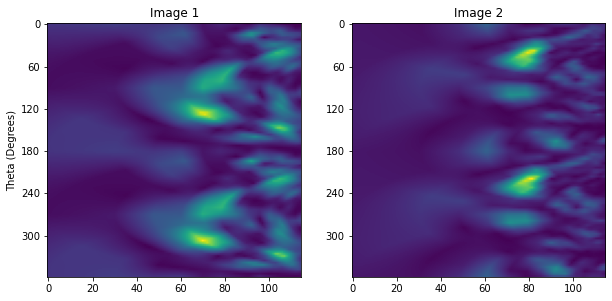

In [7]:
# Create log-polar transformed FFT mag images and register
radius = image1_fs.shape[0] // 8  # only take lower frequencies
warped_image1_fs = skimage.transform.warp_polar(image1_fs, radius=radius, output_shape=image1_fs.shape,
                             scaling='log')

warped_image2_fs = skimage.transform.warp_polar(image2_fs, radius=radius, output_shape=image1_fs.shape,
                           scaling='log')

labels =  np.arange(0,360,60)
y = labels/(360/warped_image1_fs.shape[0])

fig, axes = plt.subplots(1, 2)
ax = axes.ravel()
ax[0].set_title("Image 1")
ax[0].imshow(warped_image1_fs)
ax[0].set_yticks(y, minor=False)
ax[0].set_yticklabels(labels)
ax[0].set_ylabel('Theta (Degrees)')


ax[1].set_title("Image 2")
ax[1].imshow(warped_image2_fs)
ax[1].set_yticks(y, minor=False)
ax[1].set_yticklabels(labels)
plt.show()

Now we can compute the cross-correlation of the two transformed PSDs. This will allow us to find the translation between them that best matches, enabling us to compute the best matching rotation.

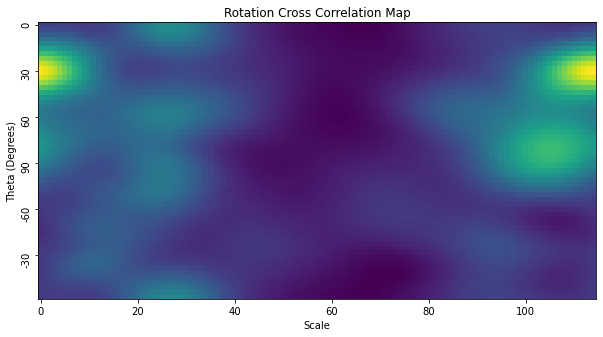

In [8]:
warped_image1_fs = warped_image1_fs[:image1_fs.shape[0] // 2, :]  # only use half of FFT, because it's symetrical
warped_image2_fs = warped_image2_fs[:image1_fs.shape[0] // 2, :]

cross_correlation, shifts = phase_cross_correlation(warped_image1_fs, warped_image2_fs)

labels =  [0, 30, 60, 90, -60, -30]
y = np.arange(0,180,30) / (180 / cross_correlation.shape[0])

plt.title ("Rotation Cross Correlation Map")
plt.imshow(cross_correlation)
plt.xlabel('Scale')
plt.yticks(y, labels, rotation='vertical')
plt.ylabel('Theta (Degrees)')
plt.show()

The log-polar transform allows us to find both changes in rotation and scale, but we know that the scale between the two images is constant. This corresponds to the leftmost column of the map, and if we plot this in 2D, we can see a peak at 30 degrees. 

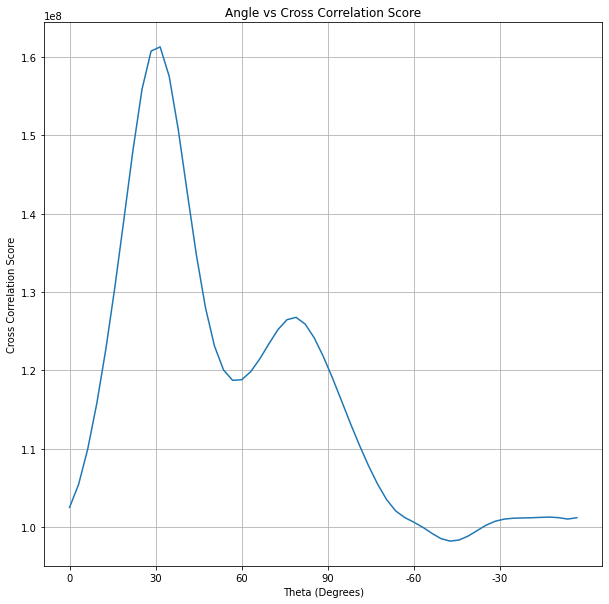

In [9]:
cross_correlation_score = cross_correlation[:,0].ravel()
plt.plot(cross_correlation_score)


labels =  [0, 30, 60, 90, -60, -30]
x = np.arange(0,180,30) / (180 / cross_correlation.shape[0])

plt.title('Angle vs Cross Correlation Score')
plt.xticks(x, labels)
plt.xlabel('Theta (Degrees)')
plt.ylabel('Cross Correlation Score')
plt.grid()
plt.show()

In [10]:
recovered_angle_degrees = (360 / image1_fs.shape[0]) * np.argmax(cross_correlation_score)

print(recovered_angle_degrees)
if recovered_angle_degrees > 90:
    recovered_angle_degrees = recovered_angle_degrees - 180

print(f"Computed rotation: {recovered_angle_degrees:.1f} degrees")

31.304347826086957
Computed rotation: 31.3 degrees


## Finding the Translation

Now it's time to find the rotation. Our first task is to rotate the img2 so that its orientation matches img1.

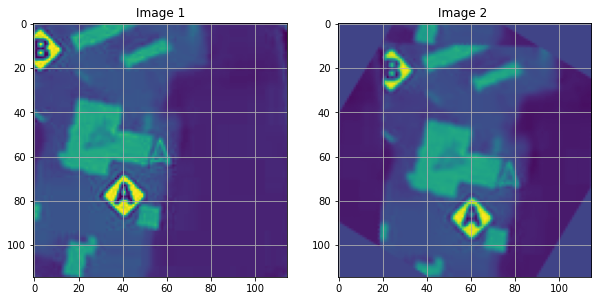

In [11]:
img2_rotated = skimage.transform.rotate(img2, -recovered_angle_degrees)

fig, axes = plt.subplots(1, 2)
ax = axes.ravel()
ax[0].set_title("Image 1")
ax[0].imshow(img1)
ax[0].grid()
ax[1].set_title("Image 2 ")
ax[1].imshow(img2_rotated)
ax[1].grid()
plt.show()

Now that the orientations of both images match, we can find the translation between the two images using cross-correlation. As before, we first window both images to reduce edge effects.

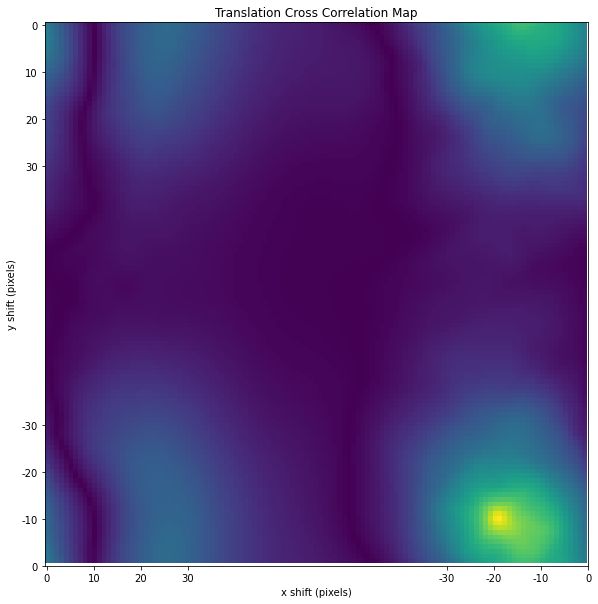

In [12]:
wimage_1 = img1 * skimage.filters.window('hann', img1.shape)
wimage_2_rotated = img2_rotated * skimage.filters.window('hann',img2.shape)
cross_correlation, shift = phase_cross_correlation(wimage_1, wimage_2_rotated)

plt.title ("Translation Cross Correlation Map")
plt.imshow(cross_correlation)
plt.xlabel('x shift (pixels)')
plt.ylabel('y shift (pixels)')

labels =  [0,10,20,30,0,-10,-20,-30]
tick_location = [0,10,20,30,115,115-10,115-20,115-30]

plt.xticks(tick_location, labels)
plt.yticks(tick_location, labels)
plt.show()

We can see a peak in the bottom right corner of the cross-correlation map, which corresponds to a shift down and the right by 10 and 20 pixels, respectively, between the first and second images. We can now correct the second image to align perfectly with the first image.

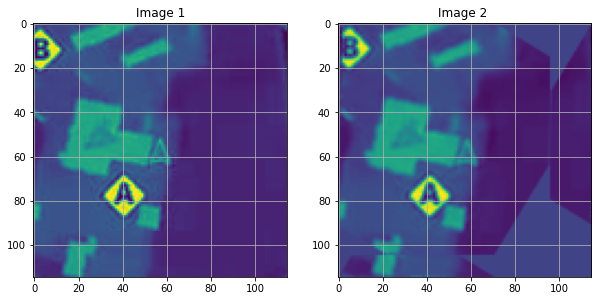

In [13]:
shift_x =  int(shift[1])
shift_y =  int(shift[0])

translated = np.roll(img2_rotated, shift_y, axis=0)
translated = np.roll(translated, shift_x, axis=1)

fig, axes = plt.subplots(1, 2)
ax = axes.ravel()
ax[0].set_title("Image 1")
ax[0].imshow(img1)
ax[0].grid()
ax[1].set_title("Image 2 ")
ax[1].imshow(translated)
ax[1].grid()
plt.show()

## Conclusion

We can now find the rotation and translation between two different images. I want to emphasise that this is one of many ways to solve the problem of finding the rotation and translation between two images.